In [1]:
# Script to evaluate citation delay
# Backward citation - citation made by a patent
# Forward citation - citation received by a patent

# Renato Kogeyama

# Aug 19, 2020
# Included gzip
# Run with latest database


# Feb 07, 2020
# The main offensor of performance in this script is the transformation to timedelta
# the solution is to change to numpy
# https://stackoverflow.com/questions/52274356/conversion-of-a-timedelta-to-int-very-slow-in-python

# Jan 17 2020
# Join cit_delay with var_builder
# The only thing var_builder was doing was including kind and type 


# Jan 03 2020
# Miami
# I am using this script to calculate the average delay in citation - to follow Hall et al, 2001
# patent.csv has the following columns
# id 	type 	number 	country 	date 	abstract 	title 	kind 	num_claims 	filename
# interest on id, type, date, kind, num_claims

# I use two sources, uspatentcitation.tsv and patent.csv
# The first is a citation-level dataset with information about the citing patent
# The second is a patent-level dataset with information about the patent

# Cleaning
# I tested in other scripts the quality of the patent identifier
# It does not require cleaning - only 4 erros from 6 million patents
# The cleaning script is there anyway

# Merging
# I merge on the citation level (df)


# --

# First U.S. Patent Issued Today in 1790


# July 31, 2001
# Press Release
# #01-33

# On July 31, 1790 Samuel Hopkins was issued the first patent for a process 
# of making potash, an ingredient used in fertilizer. The patent was signed by 
# President George Washington. Hopkins was born in Vermont, but was living in 
# Philadelphia, Pa. when the patent was granted.

# The first patent, as well as the more than 6 million patents issued since then, 
# can be seen on the Department of Commerce's United States Patent and Trademark 
# Office website at www.uspto.gov. The original document is in the collections of 
# the Chicago Historical Society.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip

In [3]:
%matplotlib inline

In [4]:
citation_df = '/home/rkogeyam/PATENT_CITATION/data/cleanuspatentcitation.csv.gz'
# cit_tree = '/home/rkogeyam/PATENT_CITATION/data/cit_tree.csv'

patent= 'data/cleanpatent.csv.gz'
dst='data/var_builder.csv.gz'

# citation_df = r'/home/rkogeyam/PATENT_CITATION/data/uspatentcitation.tsv'
# dst = '/home/rkogeyam/PATENT_CITATION/data/back_cit_delay.csv'
# dst_forw = '/home/rkogeyam/PATENT_CITATION/data/forw_cit_delay.csv'

In [5]:
%%time
file_citation=gzip.open(citation_df, 'r')
df = pd.read_csv(file_citation, usecols=['patent_id', 'citation_id', 'date'], dtype=object)

CPU times: user 3min 57s, sys: 9.21 s, total: 4min 6s
Wall time: 4min 6s


In [6]:
%%time
file_patent=gzip.open(patent, 'r')
pt_df = pd.read_csv(file_patent, usecols=['id', 'date'],index_col=0, dtype=object)

CPU times: user 1min, sys: 708 ms, total: 1min
Wall time: 1min


In [7]:
# df=df.iloc[:,1:]

In [8]:
df.head()
# df.get_chunk().head()

,patent_id,citation_id,date
0,5354551,4875247,1989-10-01
1,D674253,D519335,2006-04-01
2,D809697,1963218,1934-06-01
3,D808172,7207426,2007-04-01
4,8683318,6642945,2003-11-01


In [9]:
pt_df.head()
# pt_df.get_chunk().head()

,date
id,
10000000,2018-06-19
10000001,2018-06-19
10000002,2018-06-19
10000003,2018-06-19
10000004,2018-06-19


In [10]:
%%time
df=df.rename(columns = {'date':'citation_date'})
df['citation_date']=pd.to_datetime(df['citation_date'], format="%Y-%m-%d", errors='coerce') 
# df['citation_date'].apply[lambda x: np.datetime64(x)]

CPU times: user 44.1 s, sys: 1.8 s, total: 45.9 s
Wall time: 45.7 s


In [11]:
%%time
# merge between patent data and citations on patent_id (citing)
# merging on the citation dataset drops patents without citing
# later i could standardize to make patent_id index and use join instead of merge

df=pd.merge(df, pt_df, how='inner', left_on='patent_id', right_index=True)

CPU times: user 1min 49s, sys: 3.75 s, total: 1min 53s
Wall time: 1min 53s


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108913836 entries, 0 to 108913426
Data columns (total 4 columns):
patent_id        object
citation_id      object
citation_date    datetime64[ns]
date             object
dtypes: datetime64[ns](1), object(3)
memory usage: 4.1+ GB


In [13]:
%%time
# date format to allow calculations
df=df.rename(columns = {'date':'patent_date'})
df['patent_date']=pd.to_datetime(df['patent_date'], format="%Y-%m-%d", errors='coerce') #conversao de string para data
# df['patent_date'].apply[lambda x: np.datetime64(x)]

CPU times: user 1min 36s, sys: 2.31 s, total: 1min 38s
Wall time: 1min 38s


In [14]:
# df.shape

In [15]:
# if I do not drop nans, the script raises an error later when converting day interval into years
# I could substitute with average instead of dropping, this way I do not lose the citation info
# however, not always it will be possible to average - cases where there is ony one citation, for example
# For this reason, at this point, I'll keep the NAN and circumvent the issues as they arise

# df=df.dropna()

In [16]:
# df.shape

In [17]:
%%time
# delay is the time interval between grant and citation
df['cit_delay']=df['patent_date'].sub(df['citation_date'], axis=0)

# convert to date format
df['cit_delay']=pd.to_timedelta(df['cit_delay'])

CPU times: user 1.05 s, sys: 1.08 s, total: 2.13 s
Wall time: 2.13 s


In [18]:
df.sort_values('cit_delay').head()

,patent_id,citation_id,citation_date,patent_date,cit_delay
15708435,4937851,3927265,2197-11-01,1990-06-26,-75734 days
81215407,4996808,4813733,2198-03-01,1991-03-05,-75602 days
69676570,D299950,3113172,2196-01-01,1989-02-21,-75554 days
67461904,5012750,3717700,2197-09-01,1991-05-07,-75358 days
71936324,5055000,2701529,2195-09-01,1991-10-08,-74473 days


In [19]:
df.sort_values('cit_delay').tail()

,patent_id,citation_id,citation_date,patent_date,cit_delay
94658881,5352668,4829000,NaT,1994-10-04,NaT
95890021,3951747,NaN,NaT,1976-04-20,NaT
103146311,5227743,4858219,NaT,1993-07-13,NaT
99613891,3962287,3769337,NaT,1976-06-08,NaT
106325556,3948899,NaN,NaT,1976-04-06,NaT


In [20]:
# def convert_to_delta(x):
#     try:
#         return x/np.timedelta64(1, 'Y')
#     except:
#         return np.nan


In [21]:
%%time
# convert to interval in years
# df['cit_delay']=df['cit_delay'].dt.days/360

# this is the may offensor of performance
# change to numpy
# https://stackoverflow.com/questions/52274356/conversion-of-a-timedelta-to-int-very-slow-in-python

# this takes 40min
df['cit_delay']=pd.to_timedelta(df['cit_delay']).dt.components.days/365

# lets try this alternative
# df['cit_delay']=df['cit_delay'].apply(lambda x: convert_to_delta(x))
# does not work

CPU times: user 47min 25s, sys: 57.7 s, total: 48min 22s
Wall time: 48min 22s


In [22]:
df.describe()

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,cit_delay
count,1.089120e+08
mean,1.555897e+01
std,1.559116e+01
min,-2.074904e+02
25%,NaN
50%,NaN
75%,NaN
max,2.151507e+02


In [23]:
df.head()

,patent_id,citation_id,citation_date,patent_date,cit_delay
0,5354551,4875247,1989-10-01,1994-10-11,5.030137
11692885,5354551,1421911,1922-07-01,1994-10-11,72.328767
14307661,5354551,3902509,1975-09-01,1994-10-11,19.123288
19454029,5354551,2389736,1945-11-01,1994-10-11,48.975342
21374564,5354551,2673364,1954-03-01,1994-10-11,40.641096


CPU times: user 2.46 s, sys: 327 ms, total: 2.79 s
Wall time: 2.79 s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1eb074f60>]], dtype=object)

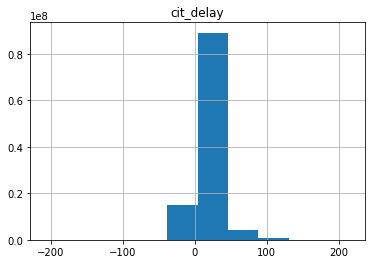

In [24]:
%%time
df.hist()

In [25]:
#Check outliers
df[df["cit_delay"]>df["cit_delay"].quantile(0.15)].sort_values(by=['cit_delay'], ascending=True)

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,patent_id,citation_id,citation_date,patent_date,cit_delay


In [26]:
df.head()

,patent_id,citation_id,citation_date,patent_date,cit_delay
0,5354551,4875247,1989-10-01,1994-10-11,5.030137
11692885,5354551,1421911,1922-07-01,1994-10-11,72.328767
14307661,5354551,3902509,1975-09-01,1994-10-11,19.123288
19454029,5354551,2389736,1945-11-01,1994-10-11,48.975342
21374564,5354551,2673364,1954-03-01,1994-10-11,40.641096


In [27]:
df[df["cit_delay"]<df["cit_delay"].quantile(0.85)].sort_values(by=['cit_delay'], ascending=False)

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,patent_id,citation_id,citation_date,patent_date,cit_delay


In [28]:
df.to_csv(dst, compression='gzip')